In [150]:
# For math operations
import numpy as np

# For dataframe operations
import pandas as pd

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Pre processing libraries
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# splitting the dataset
from sklearn.model_selection import train_test_split

# Boosting Algorithm
from xgboost import XGBRegressor

# Evaluation metric
from sklearn.metrics import mean_squared_log_error


import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
#loading the data

train = pd.read_csv('/content/TRAIN.csv')
test = pd.read_csv('/content/TEST_FINAL.csv')

### Exploratory Data Analysis

In [3]:
#shape of training and testing data
train.shape

(188340, 10)

In [4]:
#printing the first five rows of train dataset
train.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [5]:
#printing the first five rows of train dataset
train.tail()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
188335,T1188336,149,S2,L3,R2,2019-05-31,1,Yes,51,37272.00
188336,T1188337,153,S4,L2,R1,2019-05-31,1,No,90,54572.64
188337,T1188338,154,S1,L3,R2,2019-05-31,1,No,56,31624.56
188338,T1188339,155,S3,L1,R2,2019-05-31,1,Yes,70,49162.41
188339,T1188340,152,S2,L1,R1,2019-05-31,1,No,47,37977.00


In [6]:
# description of the data
train.describe()

,Store_id,Holiday,#Order,Sales
count,188340.000000,188340.000000,188340.000000,188340.000000
mean,183.000000,0.131783,68.205692,42784.327982
std,105.366308,0.338256,30.467415,18456.708302
min,1.000000,0.000000,0.000000,0.000000
25%,92.000000,0.000000,48.000000,30426.000000
50%,183.000000,0.000000,63.000000,39678.000000
75%,274.000000,0.000000,82.000000,51909.000000
max,365.000000,1.000000,371.000000,247215.000000


### Understanding the unbalance

In [7]:
train.head(4)

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16


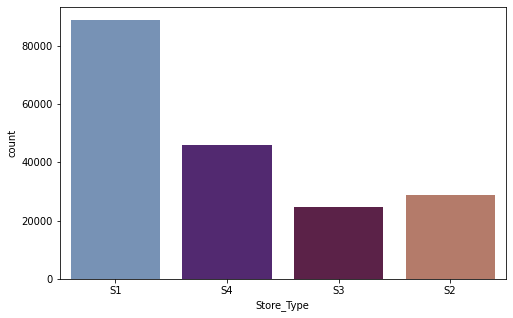

In [10]:
plt.figure(figsize=(8,5))
sns.countplot('Store_Type',data=train,palette='twilight')

More sales from store type S1

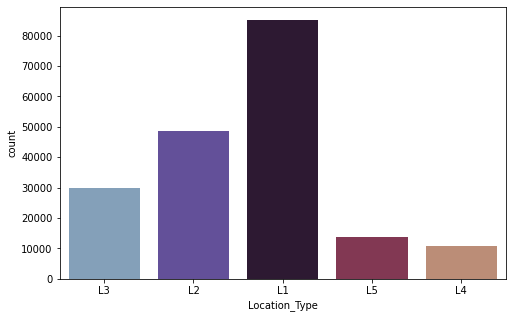

In [11]:
plt.figure(figsize=(8,5))
sns.countplot('Location_Type',data=train,palette='twilight')

More sales from Location type L1

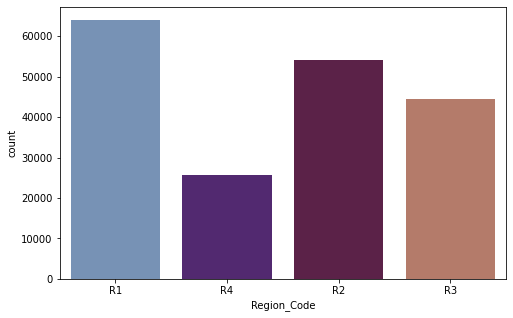

In [12]:
plt.figure(figsize=(8,5))
sns.countplot('Region_Code',data=train,palette='twilight')

More sales from Region code R1

## Feature engineering

### Cleaning data

**Missing values**

In [13]:
# Checking missing values:
print("missing values in train dataset: ", train.isnull().sum().sum())
print("missing values in test dataset: ", test.isnull().sum().sum())

missing values in train dataset:  0
missing values in test dataset:  0


There are no missing values in the dataset

**Duplicate records**

In [14]:
# Checking for any duplicated records:
print("No. of duplicate records in train dataset: ", train.duplicated().sum())
print("No. of duplicate records in test dataset: ", test.duplicated().sum())

No. of duplicate records in train dataset:  0
No. of duplicate records in test dataset:  0


There are no duplicate records in the dataset

*Removing the unimportant columns*


*   *ID - Unique for every record*
*   *#Order - The test dataset doesn't contain any such column.*


In [135]:
# Dropping the unimportant columns

train_v1 = train.drop(columns=['ID', '#Order'], axis=1)
test_v1 = test.drop(columns=['ID'], axis=1)

In [136]:
train_v1.head(2)

,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Sales
0,1,S1,L3,R1,2018-01-01,1,Yes,7011.84
1,253,S4,L2,R1,2018-01-01,1,Yes,51789.12


In [137]:
test_v1.head(2)

,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount
0,171,S4,L2,R3,2019-06-01,0,No
1,172,S1,L1,R1,2019-06-01,0,No


Getting a glimpse of the categorical columns

In [138]:
# Displaying datatypes
train_v1.dtypes

Store_id           int64
Store_Type        object
Location_Type     object
Region_Code       object
Date              object
Holiday            int64
Discount          object
Sales            float64
dtype: object

We have five categorical columns:

1. Store_Type
2. Location_Type
3. Region_Code
4. Date
5. Discount

Encoding the 'Date' column

In [140]:
train_v1['Date'] = pd.to_datetime(train_v1['Date'], format='%Y-%m-%d')
test_v1['Date'] = pd.to_datetime(test_v1['Date'], format='%Y-%m-%d')

In [141]:
train_v1.head(2)

,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Sales
0,1,S1,L3,R1,2018-01-01,1,Yes,7011.84
1,253,S4,L2,R1,2018-01-01,1,Yes,51789.12


In [142]:
test_v1.head(2)

,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount
0,171,S4,L2,R3,2019-06-01,0,No
1,172,S1,L1,R1,2019-06-01,0,No


In [143]:
train_v1.dtypes

Store_id                  int64
Store_Type               object
Location_Type            object
Region_Code              object
Date             datetime64[ns]
Holiday                   int64
Discount                 object
Sales                   float64
dtype: object

In [148]:
# function for encoding date into day, month and year
def encode_date(dataframe, column):
  dataframe["Day"] = dataframe[column].dt.day
  dataframe["Month"] = dataframe[column].dt.month
  dataframe["Year"] = dataframe[column].dt.year
  dataframe["DayOfYear"] = dataframe[column].dt.dayofyear
  dataframe["WeekOfYear"] = dataframe[column].dt.weekofyear

In [149]:
# for train data
encode_date(train_v1, 'Date')

# for test data
encode_date(test_v1, 'Date')

In [151]:
print(train_v1.head(5))
print(test_v1.head(5))

   Store_id Store_Type Location_Type  ...  Year DayOfYear  WeekOfYear
0         1         S1            L3  ...  2018         1           1
1       253         S4            L2  ...  2018         1           1
2       252         S3            L2  ...  2018         1           1
3       251         S2            L3  ...  2018         1           1
4       250         S2            L3  ...  2018         1           1

[5 rows x 13 columns]
   Store_id Store_Type Location_Type  ...  Year DayOfYear  WeekOfYear
0       171         S4            L2  ...  2019       152          22
1       172         S1            L1  ...  2019       152          22
2       173         S4            L2  ...  2019       152          22
3       174         S1            L1  ...  2019       152          22
4       170         S1            L1  ...  2019       152          22

[5 rows x 12 columns]


Categorical variable analysis for applying OneHot Encoding / Label Encoding

In [96]:
train_v1['Store_Type'].value_counts()

S1    88752
S4    45924
S2    28896
S3    24768
Name: Store_Type, dtype: int64

In [97]:
train_v1['Location_Type'].value_counts()

L1    85140
L2    48504
L3    29928
L5    13932
L4    10836
Name: Location_Type, dtype: int64

In [98]:
train_v1['Region_Code'].value_counts()

R1    63984
R2    54180
R3    44376
R4    25800
Name: Region_Code, dtype: int64

In [99]:
train_v1['Discount'].value_counts()

No     104051
Yes     84289
Name: Discount, dtype: int64

The following categorical features will be encoded with One Hot Encoding, since, they are nominal variables and they have more than two types:

1. Store_Type
2. Location_Type
3. Region_Code

The following categorical feature will be encoded with Label Encoder since it has only two type, either 'yes' or 'no'

*   Discount



Label Encoding

In [152]:
# label_encoder object
label_encoder = LabelEncoder()

# Encode labels in column 'Discount'.
train_v1['Discount_encoded']= label_encoder.fit_transform(train_v1['Discount'])
test_v1['Discount_encoded']= label_encoder.fit_transform(test_v1['Discount'])

In [153]:
train_v1.head(5)

,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Sales,Day,Month,Year,DayOfYear,WeekOfYear,Discount_encoded
0,1,S1,L3,R1,2018-01-01,1,Yes,7011.84,1,1,2018,1,1,1
1,253,S4,L2,R1,2018-01-01,1,Yes,51789.12,1,1,2018,1,1,1
2,252,S3,L2,R1,2018-01-01,1,Yes,36868.20,1,1,2018,1,1,1
3,251,S2,L3,R1,2018-01-01,1,Yes,19715.16,1,1,2018,1,1,1
4,250,S2,L3,R4,2018-01-01,1,Yes,45614.52,1,1,2018,1,1,1


In [229]:
train_v2 = train_v1.drop(columns=['Date', 'Discount'])
test_v2 = test_v1.drop(columns=['Date', 'Discount'])

In [230]:
train_v2.head(2)

,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Sales,Day,Month,Year,DayOfYear,WeekOfYear,Discount_encoded
0,1,S1,L3,R1,1,7011.84,1,1,2018,1,1,1
1,253,S4,L2,R1,1,51789.12,1,1,2018,1,1,1


In [231]:
test_v2.head(2)

,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Day,Month,Year,DayOfYear,WeekOfYear,Discount_encoded
0,171,S4,L2,R3,0,1,6,2019,152,22,0
1,172,S1,L1,R1,0,1,6,2019,152,22,0


One Hot Encoding

In [232]:
# One hot encoding
train_v2 = pd.get_dummies(train_v2)
test_v2 = pd.get_dummies(test_v2)

In [233]:
print(train_v2.head(2))
print(test_v2.head(2))

   Store_id  Holiday     Sales  ...  Region_Code_R2  Region_Code_R3  Region_Code_R4
0         1        1   7011.84  ...               0               0               0
1       253        1  51789.12  ...               0               0               0

[2 rows x 22 columns]
   Store_id  Holiday  Day  ...  Region_Code_R2  Region_Code_R3  Region_Code_R4
0       171        0    1  ...               0               1               0
1       172        0    1  ...               0               0               0

[2 rows x 21 columns]


One Hot Encoding successfully implemented !

**Feature generation with Binning on the Store_id column**

In [113]:
print("Minimun value: ", train_v2['Store_id'].min())
print("Maximum value: ", train_v2['Store_id'].max())

Minimun value:  1
Maximum value:  365


In [107]:
train_v2['Store_id'].value_counts()

255    516
38     516
294    516
39     516
167    516
      ... 
337    516
82     516
210    516
338    516
128    516
Name: Store_id, Length: 365, dtype: int64

In [108]:
train_v2.head(10)

,Store_id,Holiday,Sales,Day,Month,Year,DayOfYear,WeekOfYear,Discount_encoded,Store_Type_S1,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L1,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R1,Region_Code_R2,Region_Code_R3,Region_Code_R4
0,1,1,7011.84,1,1,2018,1,1,1,1,0,0,0,0,0,1,0,0,1,0,0,0
1,253,1,51789.12,1,1,2018,1,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0
2,252,1,36868.20,1,1,2018,1,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0
3,251,1,19715.16,1,1,2018,1,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0
4,250,1,45614.52,1,1,2018,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1
5,249,1,34211.22,1,1,2018,1,1,1,1,0,0,0,0,0,1,0,0,0,1,0,0
6,248,1,35352.66,1,1,2018,1,1,1,1,0,0,0,1,0,0,0,0,0,1,0,0
7,247,1,52650.00,1,1,2018,1,1,1,1,0,0,0,1,0,0,0,0,0,0,1,0
8,246,1,42633.78,1,1,2018,1,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0
9,254,1,62572.80,1,1,2018,1,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0


In [109]:
train_v2.tail(10)

,Store_id,Holiday,Sales,Day,Month,Year,DayOfYear,WeekOfYear,Discount_encoded,Store_Type_S1,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L1,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R1,Region_Code_R2,Region_Code_R3,Region_Code_R4
188330,147,1,48026.88,31,5,2019,151,22,0,0,0,0,1,0,1,0,0,0,0,0,0,1
188331,31,1,27760.08,31,5,2019,151,22,0,1,0,0,0,0,0,0,0,1,0,1,0,0
188332,150,1,86994.18,31,5,2019,151,22,1,0,0,0,1,0,1,0,0,0,1,0,0,0
188333,339,1,50018.34,31,5,2019,151,22,0,0,0,0,1,0,1,0,0,0,1,0,0,0
188334,151,1,24105.60,31,5,2019,151,22,0,1,0,0,0,0,0,1,0,0,0,1,0,0
188335,149,1,37272.00,31,5,2019,151,22,1,0,1,0,0,0,0,1,0,0,0,1,0,0
188336,153,1,54572.64,31,5,2019,151,22,0,0,0,0,1,0,1,0,0,0,1,0,0,0
188337,154,1,31624.56,31,5,2019,151,22,0,1,0,0,0,0,0,1,0,0,0,1,0,0
188338,155,1,49162.41,31,5,2019,151,22,1,0,0,1,0,1,0,0,0,0,0,1,0,0
188339,152,1,37977.00,31,5,2019,151,22,0,0,1,0,0,1,0,0,0,0,1,0,0,0


### Scaling

In [234]:
train_features = train_v2.drop('Sales', axis=1)
train_target = train_v2['Sales']

In [164]:
test_v2.columns

Index(['Store_id', 'Holiday', 'Day', 'Month', 'Year', 'DayOfYear',
       'WeekOfYear', 'Discount_encoded', 'Store_Type_S1', 'Store_Type_S2',
       'Store_Type_S3', 'Store_Type_S4', 'Location_Type_L1',
       'Location_Type_L2', 'Location_Type_L3', 'Location_Type_L4',
       'Location_Type_L5', 'Region_Code_R1', 'Region_Code_R2',
       'Region_Code_R3', 'Region_Code_R4'],
      dtype='object')

In [165]:
train_v2.columns

Index(['Store_id', 'Holiday', 'Sales', 'Day', 'Month', 'Year', 'DayOfYear',
       'WeekOfYear', 'Discount_encoded', 'Store_Type_S1', 'Store_Type_S2',
       'Store_Type_S3', 'Store_Type_S4', 'Location_Type_L1',
       'Location_Type_L2', 'Location_Type_L3', 'Location_Type_L4',
       'Location_Type_L5', 'Region_Code_R1', 'Region_Code_R2',
       'Region_Code_R3', 'Region_Code_R4'],
      dtype='object')

In [235]:
# fit scaler on training data
norm = MinMaxScaler().fit(train_features)

# transform training data
X_train_norm = norm.transform(train_features)

# transform testing data
X_test_norm = norm.transform(test_v2)

### Validating model

In [237]:
X_train, X_val, y_train, y_val = train_test_split(X_train_norm, train_target, test_size=0.25, random_state=42)

In [238]:
xgbr = XGBRegressor(n_estimators = 100, 
                    early_stopping_rounds=20, 
                    eta=0.1, 
                    random_state=42, 
                    objective='reg:squarederror')

xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=20,
             eta=0.1, gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [240]:
y_pred = xgbr.predict(X_val)

submission = pd.DataFrame()
submission['Sales'] = y_pred

submission['Sales'] = submission['Sales'].apply(lambda x: 0 if x<0 else x)

mean_squared_log_error(y_val, submission['Sales'])*1000

89.93119073943913

### Hyperparameter tuning

Tuning max_depth and min_child_weight parameters

In [245]:
max_depth = [5, 6, 9, 10, 14]
min_child_weight = [1, 3, 5, 6, 10]
predictions = []

def tune(X_train, y_train, X_test, y_test):
  for md in max_depth:
    for mcw in min_child_weight:
      xgbr = XGBRegressor(n_estimators = 100, 
                          eta=0.1, 
                          random_state=42, 
                          max_depth=md, 
                          min_child_weight=mcw,
                          objective='reg:squarederror',
                          )
      
      xgbr.fit(X_train, y_train)
      y_pred = xgbr.predict(X_test)
      submission = pd.DataFrame()
      submission['Sales'] = y_pred
      submission['Sales'] = submission['Sales'].apply(lambda x: 0 if x<0 else x)
      msle = mean_squared_log_error(y_test, submission['Sales'])*1000
      print("max_depth= ", md, ", min_child_weight= ", mcw, ", msle= ", msle)

In [246]:
tune(X_train, y_train, X_val, y_val)

max_depth=  5 , min_child_weight=  1 , msle=  64.90924076482281
max_depth=  5 , min_child_weight=  3 , msle=  65.0380787571291
max_depth=  5 , min_child_weight=  5 , msle=  64.81151844578359
max_depth=  5 , min_child_weight=  6 , msle=  65.07946671580174
max_depth=  5 , min_child_weight=  10 , msle=  60.59291636453853
max_depth=  6 , min_child_weight=  1 , msle=  57.160622107631895
max_depth=  6 , min_child_weight=  3 , msle=  56.37021729990238
max_depth=  6 , min_child_weight=  5 , msle=  56.182396030922646
max_depth=  6 , min_child_weight=  6 , msle=  58.439139329362334
max_depth=  6 , min_child_weight=  10 , msle=  54.567119810455154
max_depth=  9 , min_child_weight=  1 , msle=  41.87465433640932
max_depth=  9 , min_child_weight=  3 , msle=  41.39439736196112
max_depth=  9 , min_child_weight=  5 , msle=  43.04246371796265
max_depth=  9 , min_child_weight=  6 , msle=  47.63992720400196
max_depth=  9 , min_child_weight=  10 , msle=  49.41746861716063
max_depth=  10 , min_child_weight=

SELECTED:

max_depth = 14

min_child_weight = 1

Tuning subsample and cosample_bytree parameters

In [247]:
subsample = [1, 0.8, 0.6, 0.3]
cosample_bytree = [1, 0.8, 0.6, 0.3]
predictions = []

def tune_more(X_train, y_train, X_test, y_test):
  for sb in subsample:
    for cb in cosample_bytree:
      xgbr = XGBRegressor(n_estimators = 100,
                          eta=0.1, 
                          random_state=42, 
                          max_depth=14, 
                          min_child_weight=1,
                          subsample=sb, 
                          cosample_bytree=cb,
                          objective='reg:squarederror'
                          )
      
      xgbr.fit(X_train, y_train)
      y_pred = xgbr.predict(X_test)
      submission = pd.DataFrame()
      submission['Sales'] = y_pred
      submission['Sales'] = submission['Sales'].apply(lambda x: 0 if x<0 else x)
      msle = mean_squared_log_error(y_test, submission['Sales'])*1000
      print("subsample= ", sb, ", cosample_bytree= ", cb, ", msle= ", msle)

In [248]:
tune_more(X_train, y_train, X_val, y_val)

subsample=  1 , cosample_bytree=  1 , msle=  38.40793682458004
subsample=  1 , cosample_bytree=  0.8 , msle=  38.40793682458004
subsample=  1 , cosample_bytree=  0.6 , msle=  38.40793682458004
subsample=  1 , cosample_bytree=  0.3 , msle=  38.40793682458004
subsample=  0.8 , cosample_bytree=  1 , msle=  39.3406112674161
subsample=  0.8 , cosample_bytree=  0.8 , msle=  39.3406112674161
subsample=  0.8 , cosample_bytree=  0.6 , msle=  39.3406112674161
subsample=  0.8 , cosample_bytree=  0.3 , msle=  39.3406112674161
subsample=  0.6 , cosample_bytree=  1 , msle=  41.607854594407584
subsample=  0.6 , cosample_bytree=  0.8 , msle=  41.607854594407584
subsample=  0.6 , cosample_bytree=  0.6 , msle=  41.607854594407584
subsample=  0.6 , cosample_bytree=  0.3 , msle=  41.607854594407584
subsample=  0.3 , cosample_bytree=  1 , msle=  43.316567559765886
subsample=  0.3 , cosample_bytree=  0.8 , msle=  43.316567559765886
subsample=  0.3 , cosample_bytree=  0.6 , msle=  43.316567559765886
subsampl

cosample_bytree doesn't make any change.

SELECTED:

subsample = 1

Tuning the alpha parameter

In [251]:
alpha = [0.5, 0.3, 0.2, 0.1, 0.05]
predictions = []

def tune_alpha(X_train, y_train, X_test, y_test):
  for a in alpha:
    xgbr = XGBRegressor(n_estimators = 100, 
                        eta=0.1, random_state=42, 
                        max_depth=14, 
                        reg_alpha= a,
                        objective='reg:squarederror'
                        )
      
    xgbr.fit(X_train, y_train)
    y_pred = xgbr.predict(X_test)
    submission = pd.DataFrame()
    submission['Sales'] = y_pred
    submission['Sales'] = submission['Sales'].apply(lambda x: 0 if x<0 else x)
    msle = mean_squared_log_error(y_test, submission['Sales'])*1000
    print("alpha= ", a, ", msle= ", msle)

In [252]:
tune_alpha(X_train, y_train, X_val, y_val)

The alpha value doesn't make any changes, so we will keep the default one.

### Final model with selected parameters

In [253]:
xgbr = XGBRegressor(n_estimators = 100, 
                    eta=0.1, 
                    random_state=42, 
                    max_depth=14, 
                    objective='reg:squarederror')

xgbr.fit(X_train, y_train)

In [ ]:
y_pred = xgbr.predict(X_val)

submission = pd.DataFrame()
submission['Sales'] = y_pred

submission['Sales'] = submission['Sales'].apply(lambda x: 0 if x<0 else x)

mean_squared_log_error(y_val, submission['Sales'])*1000

## Getting final predictions for the given test dataset


In [ ]:
xgbr = XGBRegressor(random_state=42,
                      max_depth= 14,
                      objective='reg:squarederror')

xgbr.fit(X_train_norm, train_target)

final_predictions = xgbr.predict(X_test_norm)

In [ ]:
rounded = [np.round(x) for x in final_predictions]

In [ ]:
submission = pd.DataFrame()

submission["ID"] = test["ID"]

# creating a Sales column and saving the predictions in it
submission['Sales'] = rounded
submission['Sales'] = submission['Sales'].apply(lambda x: 0 if x<0 else x)

submission.to_csv('final_submission.csv', header=True, index=False)